### Automatic Sample Detection Experiment

This jupyter notebook compares a query song and a suspected sample song to determine if the query song contains the samples. It does so by implementing a fully fixed NMF and DTW approach to automatic sample detection, described in the thesis project paper.

In [21]:
from __future__ import print_function
import matplotlib.pyplot as plt
import sys
import glob
import numpy as np
import matplotlib
import librosa
import librosa.display
import IPython.display
import joblib
import sklearn.decomposition
from sklearn.decomposition import NMF, non_negative_factorization
from sklearn.metrics.pairwise import cosine_similarity
import scipy
#import demo_bpm_extract

In [2]:
querysampleWindow = 10

n_fft = 2048
hop_size = 1024

n_components_s = 10
solver_s = 'mu'
beta_loss_s = 'frobenius'
max_iter_s = 1000

### Preproccessing

Import, cut, downsample, downmix, and RMS normalize the query (sampling) and sample audio (source/original). At this stage we also estimate the query and sample songs' bpms.

Play the clip of the imported query and pitch shifted sample audio at the end of the following two cells.

In [5]:
# import and cut query song
query_filename = 'A Tribe Called Quest - Can I Kick It ALBUM VERSION With Lyrics.wav'
query_start = 1

# import and cut sample song
sample_filename = 'Lou Reed - Walk on the Wild Side (audio).wav'
sample_start = 2

query_path = '/Volumes/MyPassport/thesis_proj/Audio/query_songs_Master_wav/' + query_filename
sample_path = '/Volumes/MyPassport/thesis_proj/Audio/sample_songs_Master_wav/' + sample_filename

y_query, sr_query = librosa.load(query_path, sr=22050, mono=True)
query_end = query_start + querysampleWindow # in seconds
query_start_samp = query_start*sr_query
query_end_samp = query_end*sr_query

y_sample, sr_sample = librosa.load(sample_path, sr=22050, mono=True)
sample_end = sample_start + querysampleWindow # in seconds
sample_start_samp = sample_start*sr_sample
sample_end_samp = sample_end*sr_sample


# cut query song
if query_end_samp > len(y_query):
    y_queryCut = y_query[int(query_start_samp):]
else:
    y_queryCut = y_query[int(query_start_samp):query_end_samp]

# cut sample song
if sample_end_samp > len(y_sample):
    y_sampleCut = y_sample[int(sample_start_samp):]
else:
    y_sampleCut = y_sample[int(sample_start_samp):sample_end_samp]

    
# get query tempo
#query_tempo = demo_bpm_extract.get_file_bpm(y_queryCut)
onset_env_q = librosa.onset.onset_strength(y_queryCut, sr=sr_query)
query_tempo = librosa.beat.tempo(onset_envelope=onset_env_q, sr=sr_query).item()

# RMS Normalize cut query
queryRMS = np.sqrt(np.sum(np.square(y_queryCut))/y_queryCut.shape[0])
y_queryRMS = y_queryCut/queryRMS

print('query length:',y_queryRMS.shape)
IPython.display.Audio(data=y_queryRMS, rate=sr_query)

query length: (220500,)


In [6]:
# pitch shift the sample by difference in bpm
#sample_tempo = demo_bpm_extract.get_file_bpm(y_sampleCut)
onset_env_s = librosa.onset.onset_strength(y_sampleCut, sr=sr_sample)
sample_tempo = librosa.beat.tempo(onset_envelope=onset_env_s, sr=sr_sample).item()
        
# pitch shift sample song
shift_factor = round((query_tempo/sample_tempo), 1)
halfsteps = 12 * (np.log(shift_factor) / np.log(2))
y_sampleE = librosa.effects.pitch_shift(y_sampleCut, sr_sample, n_steps=halfsteps)

# RMS Normalize cut and pitch shifted sample
sampleRMS = np.sqrt(np.sum(np.square(y_sampleE))/y_sampleE.shape[0])
y_sampleRMS = y_sampleE/sampleRMS

print('sample length:',y_sampleRMS.shape)
IPython.display.Audio(data=y_sampleRMS, rate=sr_sample)

sample length: (220500,)


### Spectrograms

Calculate and plot the magnitude spectrograms of the sample and query songs.

sample magSpec dim (1025, 216)
 query magSpec dim (1025, 216)


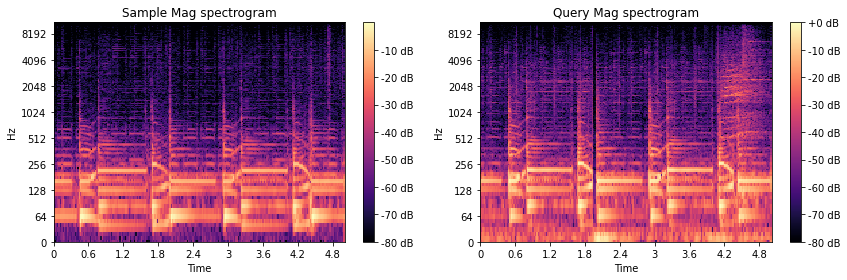

In [8]:
sample_stft = librosa.stft(y_sampleRMS, n_fft = n_fft, hop_length=hop_size)
sample_magSpec, sample_phase = librosa.magphase(sample_stft)
print('sample magSpec dim', sample_magSpec.shape)

query_stft = librosa.stft(y_queryRMS, n_fft = n_fft, hop_length=hop_size)
query_magSpec, query_phase = librosa.magphase(query_stft)
print(' query magSpec dim', query_magSpec.shape)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(sample_magSpec, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Sample Magnitude spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(query_magSpec, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Query Magnitude spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#plt.savefig('stft_demo.png')
plt.show()

### Harmonic-Percussive Source Separation

Calculate and plot the harmonic and percussive magnitude spectrograms of the sample and query songs, incase we want to use those in the PFNMF source separation steps later. It also plot the two sets of spectrograms to see.

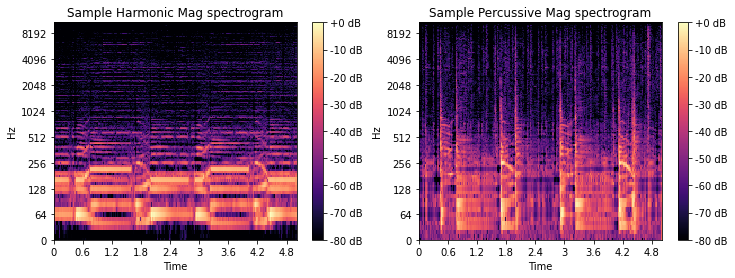

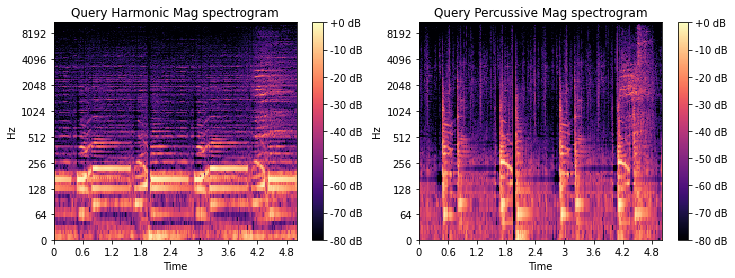

In [19]:
Hs, Ps = librosa.decompose.hpss(sample_magSpec)
Hq, Pq = librosa.decompose.hpss(query_magSpec)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Hs, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Sample Harmonic Mag spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Ps, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Sample Percussive Mag spectrogram')
plt.colorbar(format='%+2.0f dB')


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Hq, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Query Harmonic Mag spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Pq, ref=np.max), y_axis='log', x_axis='time')#, cmap='Pastel1')
plt.title('Query Percussive Mag spectrogram')
plt.colorbar(format='%+2.0f dB')

### NMF of the sample song and fully fixed NMF of the query song.

Total reconstruction error is equal to V - WH, taken as the Euclidean Distance.

The following cell visualizes the samples templates and activations, resulting from the NMF that was parameterized earlier with, n_components, solver, beta_loss, and max_iter.

    # of iterations: 530
    sample temp dim: (1025, 10)
     sample act dim: (10, 216)
recon error (total): 1800.5541003623403
 recon error (norm): 0.1380734702518254


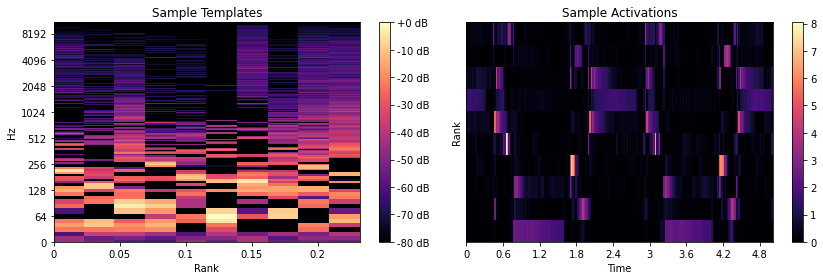

In [24]:
sample_templates, sample_activations, sample_iterations = non_negative_factorization(sample_magSpec, n_components=n_components_s, init='random', solver=solver_s, beta_loss=beta_loss_s, max_iter=max_iter_s)
print('    # of iterations:', sample_iterations)
print('    sample temp dim:', sample_templates.shape)
print('     sample act dim:', sample_activations.shape)

sample_reconerrorTotal = np.sqrt((np.square(sample_magSpec-(sample_templates.dot(sample_activations)))).sum())
# or: sample_reconerrorTotal = np.linalg.norm((sample_magSpec-sample_templates.dot(sample_activations)), ord='fro')
print('recon error (total):', sample_reconerrorTotal)

# normalize reconstruction error by the frobenious norm of the mag spec (norm1) or by total energy of mag spec.
sample_reconerrorTotal_norm1 = sample_reconerrorTotal/np.linalg.norm(sample_magSpec, ord='fro') # /sample_magSpec.sum()
print(' recon error (norm):', sample_reconerrorTotal_norm1)

# visualize its templates and acitivaztions
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(sample_templates, ref=np.max), y_axis='log', x_axis='time')
plt.xlabel('Rank')
plt.ylabel('Hz')
plt.title('Sample Templates')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(sample_activations, x_axis='time')
plt.xlabel('Time')
plt.ylabel('Rank')
plt.title('Sample Activations')
plt.colorbar()
#plt.savefig('nmfSample_demo.png')
plt.tight_layout()

### reconstruct the sample from its components and playback

The following cell reconstructs the sample spectrogram by the outer product of its templates and its activations, in order to hear what it sounds like after source separatation and reconstruction. The cell after recontructs each component, or source, for playback.

In [25]:
D_k = sample_templates.dot(sample_activations)
# Invert the stft after putting the phase back in
y_k = librosa.istft((D_k * sample_phase), hop_length=hop_size, win_length=n_fft)

# Play back the reconstruction
print('Full reconstruction')
IPython.display.Audio(data=y_k, rate=sr_sample)

Full reconstruction


In [27]:
# listen to all components in the sample song
reconstructed_signal = np.zeros(len(y_sample))
components = list()
for n in range(n_components_s):
    Y = np.outer(sample_templates[:,n], sample_activations[n])*np.exp(1j*np.angle(sample_magSpec))
    y = librosa.istft(Y)
    components.append(y)
    reconstructed_signal[:len(y)] += y
    IPython.display.display( IPython.display.Audio(y, rate=sr_sample) )

### Fully Fixed NMF

The following cell performs fully fixed nmf on the query/suspect song. Fully fixed means that the templates are initialized and never updated during the NMF, only the activations of the query are updated. Here, the templates are intialized with the templates of the sample song, calculated previously. Since Scikit learn only allows you to hold the activations constant, I switched their roles here and inverted them accordingly.

The plots look at the activations functions of both the sample and query song. If there is a strong sample relation, you may be able to see similarities instantly.

    # of iterations: 50
     query temp dim: (1025, 10)
      query act dim: (10, 216)
recon error (total): 5826.013915972251
 recon error (norm): 0.44098738095516976


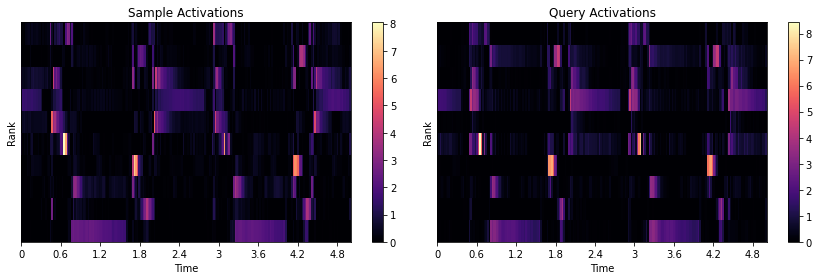

In [28]:
query_templates, query_activations, query_iterations = non_negative_factorization(query_magSpec.T, n_components=n_components_s, init='custom', update_H=False, H=sample_templates.T, solver=solver_s, beta_loss=beta_loss_s, max_iter=max_iter_s)
print('    # of iterations:', query_iterations)
print('     query temp dim:', query_activations.T.shape)
print('      query act dim:', query_templates.T.shape)

# total reconstruction error = V - WH, taken as the Euclidean Distance. Compare 2 calculations to verify:
query_reconerrorTotal = np.sqrt((np.square(query_magSpec-(query_activations.T.dot(query_templates.T)))).sum())
# or: query_reconerrorTotal = np.linalg.norm((query_magSpec-query_activations.T.dot(query_templates.T)), ord='fro')
print('recon error (total):', query_reconerrorTotal)

# normalize reconstruction error by the frobenious norm of the mag spec (norm1) or by total energy of mag spec.
query_reconerrorTotal_norm1 = query_reconerrorTotal/np.linalg.norm(query_magSpec, ord='fro') # /query_magSpec.sum()
print(' recon error (norm):', query_reconerrorTotal_norm1)

# visualize the sample activations and informed query activations side by side. In the example where sample=query
# they should match exactly. In the case of a sample relation, they should be very similar.
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(sample_activations, x_axis='time')
plt.xlabel('Time')
plt.ylabel('Rank')
plt.title('Sample Activations')
plt.colorbar()

plt.subplot(1,2,2)
librosa.display.specshow(query_templates.T, x_axis='time')
plt.xlabel('Time')
plt.ylabel('Rank')
plt.title('Query Activations')
plt.colorbar()

#plt.savefig('nmfAct_demo.png')
plt.tight_layout()

### Selective Process

This cell plots the 'selective' process that is discussed in the thesis. This proccess gets the component-wise recontruction error between the sample components and query components. Then we isolate (keep) the query
components with the lowest distances from the sample components, suspecting that these componoents are more likely to contain the sample.

In [41]:
lowestQueryComponents = []
lQC_array = np.array(lowestQueryComponents, dtype = np.float32)

query_activations_new = np.empty([0, query_templates.shape[0]], dtype = np.float32)
query_templates_new = np.empty([0, query_activations.shape[1]], dtype = np.float32)

sample_activations_new = np.empty([0, sample_activations.shape[1]], dtype = np.float32)
sample_templates_new = np.empty([0, sample_templates.shape[0]], dtype = np.float32)

for n in range(n_components_s):
    for nn in range(n_components_s):
        dictDist1 = sample_templates[:,n] - query_activations.T[:,nn]
        dictEuclidean_normalized = np.sqrt((np.square(dictDist1)).sum())/query_activations.T.sum()
        lQC_array = np.append(lQC_array, dictEuclidean_normalized)
        print(n, nn, dictEuclidean_normalized)

    lowestqcomponentIndex = np.argmin(lQC_array)
    print('lowest activation has index', lowestqcomponentIndex)
    
    query_activationsLow = query_templates.T[lowestqcomponentIndex,:]
    print(query_activationsLow.shape)
    query_templatesLow = query_activations.T[:,lowestqcomponentIndex]
    print(query_templatesLow.shape)
    
    query_activations_new = np.vstack((query_activations_new, query_activationsLow))
    print('new activations', query_activations_new.shape)
    query_templates_new = np.vstack((query_templates_new, query_templatesLow))
    print('  new templates', query_templates_new.shape)
    
    sample_activationsLow = sample_activations[n,:]
    #print(sample_activationsLow.shape)
    sample_templatesLow = sample_templates[:,n]
    #print(sample_templatesLow.shape)
    
    sample_activations_new = np.vstack((sample_activations_new, sample_activationsLow))
    #print('new activations', sample_activations_new.shape)
    sample_templates_new = np.vstack((sample_templates_new, sample_templatesLow))
    #print('  new templates', sample_templates_new.shape)
    
    lQC_array = np.delete(lQC_array,np.s_[0:n_components_s],0)

0 0 0.0
0 1 0.03816227516172018
0 2 0.04419564413323638
0 3 0.04155756394861793
0 4 0.03716916076532363
0 5 0.059360157431208996
0 6 0.04751128112722544
0 7 0.040267936044300984
0 8 0.03373478931809724
0 9 0.037113953501232436
lowest activation has index 0
(216,)
(1025,)
new activations (1, 216)
  new templates (1, 1025)
1 0 0.03816227516172018
1 1 0.0
1 2 0.039389045357844044
1 3 0.03159715310157646
1 4 0.028950045685971586
1 5 0.05121805908214744
1 6 0.03923520896125818
1 7 0.03202871774102941
1 8 0.02616986962295765
1 9 0.027051803408054242
lowest activation has index 1
(216,)
(1025,)
new activations (2, 216)
  new templates (2, 1025)
2 0 0.04419564413323638
2 1 0.039389045357844044
2 2 0.0
2 3 0.02473352298265619
2 4 0.03642077381013437
2 5 0.056081850712891915
2 6 0.04797961742029185
2 7 0.036719362705128496
2 8 0.03459682651318133
2 9 0.03724059173604701
lowest activation has index 2
(216,)
(1025,)
new activations (3, 216)
  new templates (3, 1025)
3 0 0.04155756394861793
3 1 0.0

### Reconstructing the query song
This cell reconstructs the query spectrogram by the outer product of its templates (learned from sample) and its activations. The cell after reconstructs each query component, for playback.

In [42]:
D_kq = query_activations.T.dot(query_templates.T)

# invert the stft after putting the phase back in
y_kq = librosa.istft(D_kq * query_phase, hop_length=hop_size, win_length=n_fft)
print(y_kq.shape)

# Play back the reconstruction
print('Full reconstruction')
IPython.display.Audio(data=y_kq, rate=sr_query)

(220160,)
Full reconstruction


In [44]:
# listen to all query components (tempaltes + activations)
reconstructed_signalq = np.zeros(len(y_query))
componentsq = list()
for n in range(n_components_s):
    Yq = np.outer(query_activations.T[:,n], query_templates.T[n])*np.exp(1j*np.angle(query_magSpec))
    yq = librosa.istft(Yq)
    componentsq.append(yq)
    reconstructed_signalq[:len(yq)] += yq
    IPython.display.display( IPython.display.Audio(yq, rate=sr_query) )

### Understanding Frame-wise Reconstruction, instead of component-wise.

The first plot gets the frame-wise reconstruction error of the ffnfm between the query and newly approximated query, normalizes and displays.

The second plot gets the frame-wise reconstruction error of the ffnfm between the sample and the newly approximated query, normalizes and displays. If there is no time-misallignment in the sample, then this should be seen as low error during similarities between the sample and query. We can sweep over the signal, assuming there are no distortions in time between the sample and query, in order to solve for translations in time.

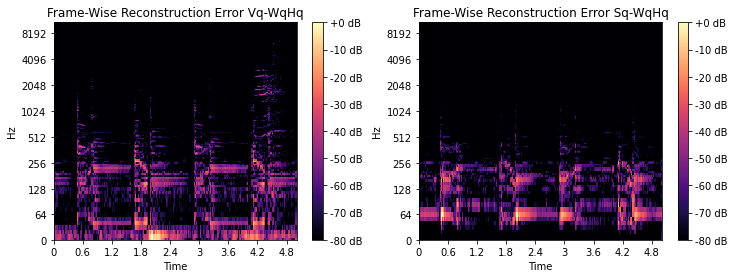

In [45]:
query_reconerrorFramewise = np.square(query_magSpec-(query_activations.T.dot(query_templates.T)))
query_reconerrorFramewise_norm = query_reconerrorFramewise/query_magSpec.sum()


reconerrorSampleQuery = np.square(sample_magSpec-(query_activations.T.dot(query_templates.T)))
reconerrorSampleQuery_norm = reconerrorSampleQuery/sample_magSpec.sum()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(query_reconerrorFramewise_norm, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frame-Wise Reconstruction Error Vq-WqHq')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(reconerrorSampleQuery_norm, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frame-Wise Reconstruction Error Sq-WqHq')
plt.colorbar(format='%+2.0f dB')

### Sweeping the signal for frame-wise reconstruction error

sweeping the signal to conduct a finer-tuned frame-wise reconstruction error. Speed up or slow down the sample to match with the query

### DTW Similarity between the sample and query templates.

This cell looks to find similarity between the original sample and query song, which had been reconstructed using the sample's templates during the fully fixed NMF earlier. It does so by conducting dynamic time warping (DTW), which compares the signals, despite distortions in time between the signals.

Experiment with metric = ‘correlation’, ‘cosine’, ‘euclidean’ for different calculations of the accumulated cost.

The cell after plots the accumulated cost and optimal warping path.

In [46]:
sample_activationsNorm = sample_activations/(np.max(sample_activations))
query_activationsNorm = query_templates.T/(np.max(query_templates.T))

D, wp = librosa.sequence.dtw(X=sample_activationsNorm, Y=query_activationsNorm, metric='cosine', subseq=True, backtrack=True)
print(D.shape)
print(wp.shape)

(216, 216)
(241, 2)


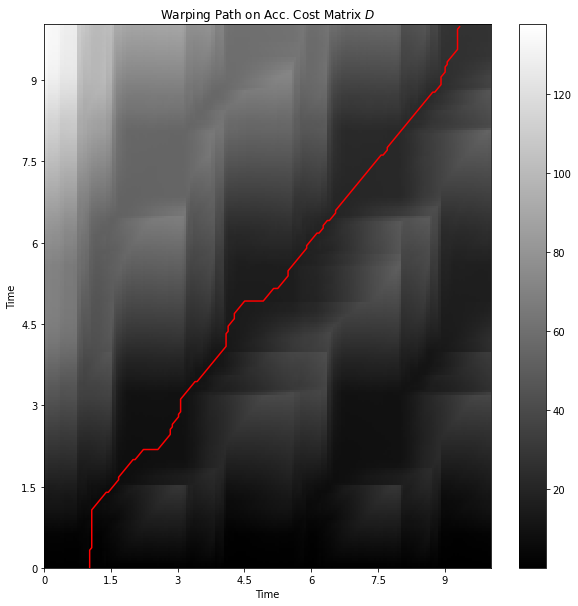

In [47]:
# Plot the Accumulated Cost Matrix
wp_s = np.asarray(wp) * hop_size / sr_sample

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)

librosa.display.specshow(D, x_axis='time', y_axis='time', cmap='gray', hop_length=hop_size)

imax = ax.imshow(D, cmap=plt.get_cmap('gray'), origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], color='r')

plt.title('Warping Path on Acc. Cost Matrix $D$')
plt.colorbar()

### Plotting the matching function

Local minima in the matching function allude to points of convergence between the sample and query song's activations.

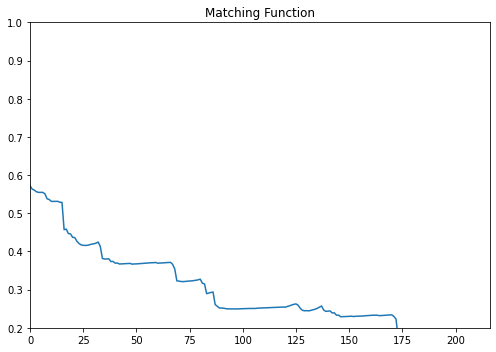

In [48]:
# visualize the sample's end points
plt.figure(figsize=(7, 5))
plt.plot(D[-1, :] / wp.shape[0])
plt.xlim([0, query_templates.T.shape[1]])
plt.ylim([.2, 1])
plt.title('Matching Function')
plt.tight_layout()
#plt.savefig('matchingfunction.png')

In [ ]:
# DTW Score...sum of the accumulated cost along the warping path
dtwScore_wp = D[wp[:,1],wp[:,0]]
dtwScore = round(dtwScore_wp.sum(),2)

print(dtwScore)

In [ ]:
# DTW Score...element in accumulated cost matrix on first element in back-tracked warping path
# this element in the warping path is where the sample (presumably) begins in the query and should have low cost
dtwScore_wp1 = D[wp[wp.shape[0]-1,1],wp[wp.shape[0]-1,0]]
dtwScore_wp1

In [ ]:
# DTW score as the minimum element in matching function
dtwScore_mf = np.min(D[-1, :] / wp.shape[0])
dtwScore_mf